[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1DCdiUvWAQR2tDcyOkSrIGfkWnOvty_e1?usp=sharing)

# Text classification with enconder transformer

source: https://keras.io/examples/nlp/text_classification_with_transformer/

## Setup

In [ ]:
## At least keras >= 3.0.0
# !pip install -q -U keras==3.0.0

In [ ]:
import keras
keras.__version__

'3.10.0'

In [ ]:
import keras
from keras import layers
import tensorflow as tf

## Download and prepare dataset

In [ ]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train =  tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
25000 Training sequences
25000 Validation sequences


## Create classifier model using transformer layer

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.

In [ ]:
embed_dim = 32
num_heads = 2
ff_dim = 32
dropout_rate = 0.1

### Create embeddings

Per each token, create embeddings from scrach during training

In [ ]:
inputs = keras.Input(shape=(maxlen,), name="input_tokens")
token_embedding = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, name="token_embedding")(inputs)

### Position embedding

Combine token and position embedding to have different embedding depend on context and position

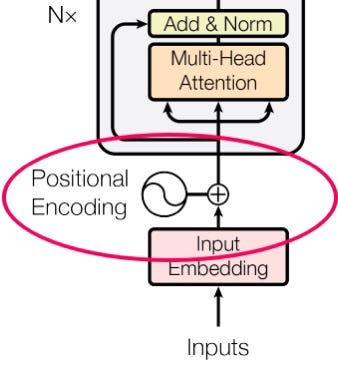

In [ ]:
# get position per each token
positions = tf.range(start=0, limit=maxlen, delta=1)

# create embeddings from the token positions
pos_embedding = layers.Embedding(input_dim=maxlen, output_dim=embed_dim, name="pos_embedding")(positions)

# expand dimension to match with token embeddings (batch dimension)
pos_embedding = tf.expand_dims(pos_embedding, axis=0)
# combine token and position embedding
x = token_embedding + pos_embedding

### Transformer block

- **Self attention**: for each token, the model computes how much attention to pay to every other token. That is, for token i, it asks: “How relevant is token j to token i?” for all.
- **Multi-head** means this attention is done in several parallel heads, each focusing on different aspects/perspectives of the sequence (syntax, semantics, relations, etc.).
- **Residual (Skip) + Layer Normalization**:
After the attention output, you add the original input of this sub-layer (skip/shortcut), then apply layer normalization. This preserves the original signal (prevent gradiend vanishing) + helps training stability
- **Feed-Forward Network (FFN)**: get hiddend dense layer to captura more relations from the previous layers. Also add residual and normalization layer for same reason than before.

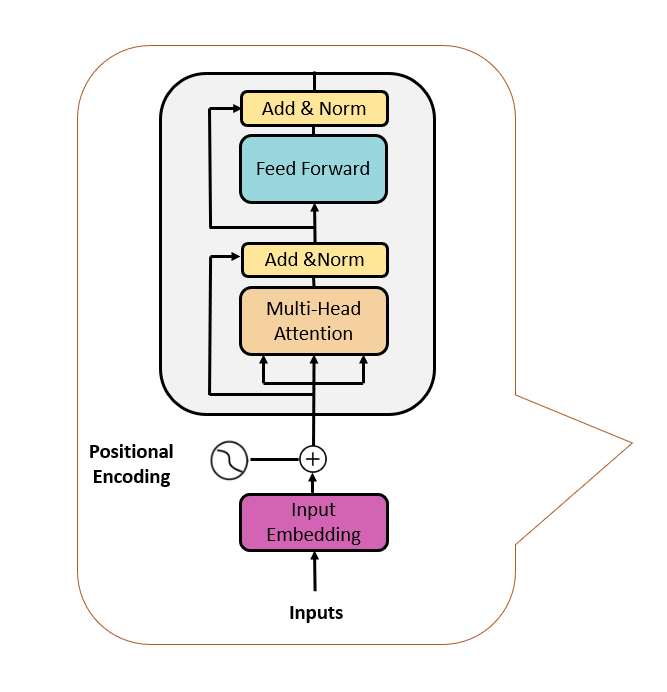

In [ ]:
# transformer block
# 1. multihead attention (self-attention)
attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name="multihead_attn")(x, x)
attn_output = layers.Dropout(dropout_rate, name="dropout_attn")(attn_output)
# residual + norm
x1 = layers.LayerNormalization(epsilon=1e-6, name="layernorm1")(x + attn_output)


In [ ]:
# 2. Feed-forward
ffn_output = layers.Dense(ff_dim, activation="relu", name="ffn_dense1")(x1)
ffn_output = layers.Dense(embed_dim, name="ffn_dense2")(ffn_output)
ffn_output = layers.Dropout(dropout_rate, name="dropout_ffn")(ffn_output)
# Residual + Norm
x2 = layers.LayerNormalization(epsilon=1e-6, name="layernorm2")(x1 + ffn_output)


### Final layer

- Pooling: create an overview of features from all tokens in the input sentence. Per each embeddings create a set of features that represent different points of view from the input sentences.
- Hidden layers + final layer: add hidden layers to explore info from last layers. Finally, create classification layer according to the problem

In [ ]:
# Pooling + final layer
x3 = layers.GlobalAveragePooling1D(name="global_avg_pool")(x2)
x3 = layers.Dropout(dropout_rate, name="dropout_final1")(x3)
x3 = layers.Dense(20, activation="relu", name="dense_relu")(x3)
x3 = layers.Dropout(dropout_rate, name="dropout_final2")(x3)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x3)

## Train and Evaluate

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs, name="simple_transformer")


model.summary()

Model: "simple_transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_tokens        │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, 200, 32)   │    640,000 │ input_tokens[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 32)   │          0 │ token_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attn      │ (None, 200, 32)   │      8,416 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_attn        │ (None, 200, 32)   │          0 │ multihead_attn[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 32)   │          0 │ add[0][0],        │
│                     │                   │            │ dropout_attn[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm1          │ (None, 200, 32)   │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense1 (Dense)  │ (None, 200, 32)   │      1,056 │ layernorm1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense2 (Dense)  │ (None, 200, 32)   │      1,056 │ ffn_dense1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_ffn         │ (None, 200, 32)   │          0 │ ffn_dense2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 32)   │          0 │ layernorm1[0][0], │
│                     │                   │            │ dropout_ffn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm2          │ (None, 200, 32)   │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 32)        │          0 │ layernorm2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_final1      │ (None, 32)        │          0 │ global_avg_pool[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_relu (Dense)  │ (None, 20)        │        660 │ dropout_final1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_final2      │ (None, 20)        │          0 │ dense_relu[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │         21 │ dropout_final2[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 651,337 (2.48 MB)

 Trainable params: 651,337 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6954 - loss: 0.5330 - val_accuracy: 0.8809 - val_loss: 0.2855
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9311 - loss: 0.1918 - val_accuracy: 0.8705 - val_loss: 0.3253
